# Import all libraries

In [13]:
import numpy as np
import torch
import networkx as nx
from Architecture.Layers import Random_RNN
import matplotlib.pyplot as plt

In [14]:
input_size = 7
hidden_size = 4
output_size = 5

model = Random_RNN(input_size, hidden_size, output_size, connect_percentage=0.1)

print(f'nodes: {len(model.graph.nodes)}\n edges: {len(model.graph.edges)}')

nodes: 16
 edges: 19


In [15]:
from torchsummary import summary

# show model summary
# summary(model, (input_size, 1))

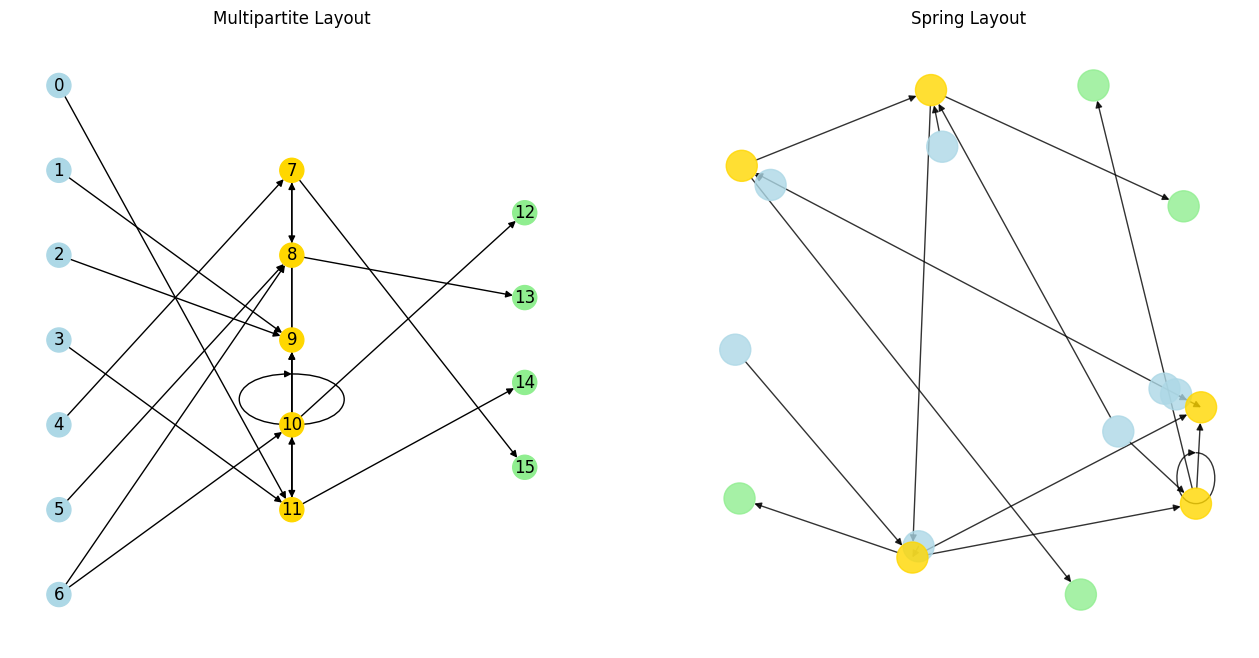

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
pos = nx.multipartite_layout(model.graph, subset_key="layer")
nx.draw(model.graph, pos, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], with_labels=True)
plt.title('Multipartite Layout')

plt.subplot(122)
nx.draw(model.graph, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], node_size=500, alpha=0.8)
plt.title('Spring Layout')

plt.show()

In [17]:
device = "cpu"

# Testing SNN Model

In [18]:
test_individ = torch.rand(5,5)
history = []

mnist_snn = MNIST_SNN(25, 5)
# optimizer = STDP(mnist_snn.parameters(), mnist_snn.spikes())

potentials_stack = torch.zeros(5)

with torch.no_grad():
    for j in range(0, 254):
            Y_pred = mnist_snn.forward(test_individ.view(-1, 5*5), j)
            history.append(Y_pred.clone())
            # optimizer.step()

            potentials_stack = torch.vstack((potentials_stack, mnist_snn.get_potentials()[1]))



# Show network parameters
# for p in MNIST_SNN.parameters(mnist_snn):
#     if p.requires_grad:
#         print(p.name, p.data.shape)
#
#         plt.figure(figsize = (14,14))
#         plt.imshow(p.data, cmap='Greys')


plt.figure(figsize = (14,14))
plt.plot(potentials_stack.T[0])
# plt.imshow(potentials_stack.T, aspect=10, cmap='Greys')

pass

NameError: name 'MNIST_SNN' is not defined

# Load MNIST

In [ ]:
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='plasma')
plt.xlabel(f"NUMBER: {ans}")
pass

# Prepare and split data into train/test

In [ ]:
split_ratio = 0.00005
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

# print(dataset.shape)
print(dataset)

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Configure NN Model and hyper-parameters

In [ ]:
mnist_snn = MNIST_SNN(28*28, 10)
optimizer = STDP(mnist_snn.parameters(), mnist_snn.spike_history(), lr=0.002)
epochs = 1

# Train loop

In [ ]:
history = []
images = []

for name, param in mnist_snn.named_parameters():
    if param.requires_grad:
        # print (name, param.data.shape)
        plt.imshow(param.data[0].reshape((28, 28)), cmap='plasma')
        break

def train_mnist_SNN():
    with torch.no_grad():
        for epoch in range(0, epochs):
            for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
                images.append(features)
                for j in range(0, 350):
                        Y_pred = mnist_snn.forward(features.view(-1, 28*28), j)
                        history.append(Y_pred.clone())
                        optimizer.step()



train_mnist_SNN()

In [ ]:


for name, param in mnist_snn.named_parameters():
    if param.requires_grad:
        if name == "encoder.weight":
            print (name, param.data.shape)

            fig = plt.figure()
            for i, img in enumerate(param.data):
                ax = fig.add_subplot(2, param.data.shape[0] // 2 + 1, i + 1)
                imgplot = plt.imshow(img.reshape((28, 28)), cmap='plasma')

            break



plt.imshow(images[0][0].view((28, 28)))

# Validation

In [ ]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_nn(features.view(-1, 28*28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")


# Visualisation test

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = mnist_nn(img.to(device).view(-1)).argmax()

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass 

# Configure CNN Model and hyper-parameters

In [ ]:
mnist_cnn = MNIST_CNN().to(device)

epochs = 2
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_cnn.parameters(), lr=0.01)

history = []
summary(mnist_cnn, (1, 28, 28), batch_size=batch_size)

# Train loop

In [ ]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader)):
        # Forward pass
        Y_pred = mnist_cnn.forward(features.view(-1, 1, 28, 28))
        # print(Y_pred.shape)

        loss = loss_func(Y_pred, ans)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 3 == 0: history.append(loss.data)

In [ ]:
plt.plot(list(map(lambda x: x.cpu(), history)))
print(f"Mean CrossEntropyLoss (last 100): {sum(history[-100:]) / 100}")

# Validation

In [ ]:
with torch.no_grad():
    answers = torch.zeros(10).to(device)
    predictions = torch.zeros(10).to(device)

    for i, (features, ans) in enumerate(tqdm(valid_batch_loader)):
        predictions = torch.vstack((predictions, nn.functional.normalize(mnist_cnn(features.view(-1, 1, 28, 28)))))

        # Convert to one-hot encoded
        ans = nn.functional.one_hot(ans, num_classes=10)

        answers = torch.vstack((answers, ans))

    print(f"MSE: {mse(predictions.T.cpu(), answers.T.cpu())}")